# Plot behavioral test performance

In [1]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pingouin as pg
from mindstorm import statplot
from bender_study import task
from bender_study import figures

bids_dir = Path(os.environ['BENDER_BIDS']) / 'rawdata'
fig_dir = Path(os.environ['BENDER_FIGURES']) / 'plots'
figures.set_style()

## Load data and calculate statistics

In [2]:
data = task.load_test_events(bids_dir)

# score no-response trials as incorrect
data['correct'] = data['correct'].fillna(False)

In [3]:
# calculate statistics for each subject and trial type
trials = ['subject', 'trial_type']
grp = data.groupby(trials)
m = grp[['pair_type']].first()
m['score'] = grp['correct'].sum()
m['correct'] = grp['correct'].mean()
m['correct_rt'] = (
    data.query('correct == 1')
    .groupby(trials)['response_time']
    .mean()
)
m['incorrect_rt'] = (
    data.query('correct == 0')
    .groupby(trials)['response_time']
    .mean()
)
m.head(8)

pair_type  score   correct  correct_rt  incorrect_rt
subject trial_type                                                     
02      AB1               AB     93  0.775000    1.681763      1.838962
        AB2               AB    111  0.925000    1.213730      1.841000
        AB3               AB    118  0.983333    1.132059      1.355000
        AB4               AB    120  1.000000    1.120558           NaN
        AC                AC     78  0.650000    3.343590      4.065450
        BC                BC    107  0.891667    2.372103      3.325154
        XY                XY     49  0.816667    2.753816      3.156636
        AB                AB    119  0.991667    1.769664      4.084000

## Response accuracy

In [4]:
# percent correct summary stats
mp = m['correct'].unstack('trial_type')
(mp * 100).agg(['mean', 'sem'])

trial_type,AB1,AB2,AB3,AB4,AC,BC,XY,AB
mean,88.833333,97.777778,98.722222,98.916667,78.166667,92.722222,86.388889,99.472222
sem,1.205696,0.375523,0.318976,0.226550,2.735813,1.702645,2.108311,0.176362


In [5]:
# AC accuracy binomial test
sp = m['score'].unstack('trial_type')
n = data.query('subject == "02"').groupby(['trial_type'])['pair_type'].count()
p = [stats.binom_test(x, n['AC'], p=1/3, alternative='greater') for x in sp['AC']]
np.max(p)

0.008682276632800794

In [6]:
# AC vs. AB
pg.ttest(mp['AB4'], mp['AC'], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,7.658487,29,two-sided,1.915333e-08,"[0.15, 0.26]",1.95165,7.052e+05,1.0


In [7]:
# AC vs. BC
pg.ttest(mp['BC'], mp['AC'], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,9.557883,29,two-sided,1.822459e-10,"[0.11, 0.18]",1.166293,5.671e+07,0.999987


In [8]:
# AC vs. XY
pg.ttest(mp['XY'], mp['AC'], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,7.299689,29,two-sided,4.859654e-08,"[0.06, 0.11]",0.614653,2.948e+05,0.902032


In [9]:
# BC vs XY
pg.ttest(mp['BC'], mp['XY'], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,5.049029,29,two-sided,0.000022,"[0.04, 0.09]",0.603422,1020.933,0.891371


## Response times on correct trials

In [10]:
rp = m['correct_rt'].unstack('trial_type')
(rp * 1000).agg(['mean', 'sem'])

trial_type,AB1,AB2,AB3,AB4,AC,BC,XY,AB
mean,1549.228424,1166.622098,1078.197729,1043.335684,2947.477063,1858.617622,2249.270559,1525.941832
sem,43.403530,30.767091,28.436656,25.679912,90.492365,66.660615,73.186048,38.850874


In [11]:
# BC vs. XY
pg.ttest(rp['XY'], rp['BC'], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,10.176979,29,two-sided,4.426203e-11,"[0.31, 0.47]",1.018911,2.168e+08,0.999696


## Plot response accuracy

In [12]:
dark = sns.color_palette(
    [
        (0.0471, 0.7451, 0.3059),
        (0.0000, 0.5451, 1.0000),
        (1.0000, 0.6510, 0.1647),
        (1.0000, 0.2784, 0.5647),
    ]
)

dark

[(0.0471, 0.7451, 0.3059),
 (0.0, 0.5451, 1.0),
 (1.0, 0.651, 0.1647),
 (1.0, 0.2784, 0.5647)]

In [13]:
light = sns.color_palette(
    [
        (0.4549, 0.8471, 0.6078),
        (0.4863, 0.7804, 1.0000),
        (1.0000, 0.8196, 0.6039),
        (1.0000, 0.5961, 0.8275),
    ]
)
light

[(0.4549, 0.8471, 0.6078),
 (0.4863, 0.7804, 1.0),
 (1.0, 0.8196, 0.6039),
 (1.0, 0.5961, 0.8275)]

LINO NOT subset; don't know how to subset; dropped


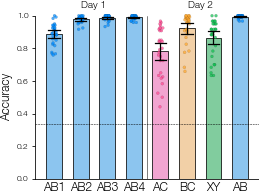

In [14]:
with plt.style.context({'font.size': 10}):
    fig, ax = plt.subplots(figsize=(4, 3))
    ax = statplot.plot_swarm_bar(
        data=m,
        x='trial_type',
        y='correct',
        hue='pair_type',
        light=light,
        dark=dark,
        point_kind='strip',
        width=.6,
        legend=False,
        ax=ax,
    )
    ax.axline((0, 1/3), slope=0, color='k', linestyle='--', linewidth=.5)
    ax.axline((3.5, 0), slope=np.Inf, color='k', linestyle='-', linewidth=.5)
    ax.set(ylim=(0, 1.0), ylabel='Accuracy')
    ax.tick_params(axis='x', length=0)
    
    fontdict = {'horizontalalignment': 'center'}
    ax.text(1.5, 1.05, 'Day 1', fontdict=fontdict)
    ax.text(5.5, 1.05, 'Day 2', fontdict=fontdict);
    
    ax.figure.savefig(fig_dir / 'accuracy.pdf')

## Plot response times for correct responses

LINO NOT subset; don't know how to subset; dropped


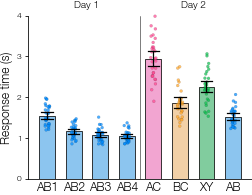

In [15]:
with plt.style.context({'font.size': 10}):
    fig, ax = plt.subplots(figsize=(4, 3))
    ax = statplot.plot_swarm_bar(
        data=m,
        x='trial_type',
        y='correct_rt',
        hue='pair_type',
        light=light,
        dark=dark,
        point_kind='strip',
        width=.6,
        legend=False,
        ax=ax,
    )
    ax.axline((3.5, 0), slope=np.Inf, color='k', linestyle='-', linewidth=.5)
    ax.set(ylim=(0, 4), ylabel='Response time (s)')
    ax.tick_params(axis='x', length=0)
    
    fontdict = {'horizontalalignment': 'center'}
    ax.text(1.5, 4.2, 'Day 1', fontdict=fontdict)
    ax.text(5.5, 4.2, 'Day 2', fontdict=fontdict);
    
    ax.figure.savefig(fig_dir / 'rt.pdf')

In [16]:
%load_ext watermark
%watermark -v -iv

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 8.3.0

mindstorm   : 0.9.0
bender_study: 0.1.0
seaborn     : 0.11.2
pingouin    : 0.5.2
scipy       : 1.8.0
matplotlib  : 3.5.1
numpy       : 1.22.3

